# Target Assessor
This notebook aims to injest a list of source descriptions and observation criteria from the STM effort, applying appropriate metric tools to assess against the critera for a list of mission concept descriptions.

To run this on Google Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnGBaker/GWI-metrics/blob/main/Notebooks/Target%20Assessor.ipynb)

### Some basic setup

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/JohnGBaker/GWI-metrics.git
    src='GWI-metrics/src/'
else:
    src='../src/'
!mkdir -p '../plots/'

# Import
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(src)
import constants
import metrics
import sources
import concepts
import subsystems
import background
import pandas as pd
from glob import glob
import re
from astropy.coordinates import Angle
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u

### Edit target info:

In [2]:
label='my source'
m1,m2=1e6,1e4;z=1.0
#optional specification of end of observation
timecut=None
#give f0 value if not a chirp
f0=None
#observation targets
res_req_arcsec=100.0
SNR_req=5

#label='1.1.b';m1,m2=1.5,1.5;z=0.05;timecut=15;res_req_arcsec=60.0 #1.1b
#label='3.1.a';m1=150.0;m2=150000000.0;z=0.5;res_req_arcsec=180 
label='5.1.a';m1=100.0;m2=10;z=0.1;res_req_arcsec=600 


### Define the set of concepts
Here we load in a set of the pre-defined concepts, or you can define your own

In [3]:
missionNames = (
    'LISACBE',
    'LISASciRDv1',
    'TwinLISA',
    'LISAGrande',
    'LISAU',
    'GoBIGLISA',
    'ALIA',
    'ALIAlowL')
missions=[concepts.menu[mission] for mission in missionNames]

for mission in missions:
    mission=background.add2model(mission)
#model = concepts.LISACBE.copy()
#modelName = model.get('label')
#model = background.add2model(model)     # add galactic background model

In [4]:
# make source dictionary
objectiveList=[]
minimumSNR=5
obj={}
obj['label']=label
obj['m1']=m1*(1+z)#convert to redshifted mass
obj['m2']=m2*(1+z)#convert to redshifted mass
dist=cosmo.luminosity_distance(z).to(u.kpc).value
obj['dl']=dist
if f0 is None: 
    obj['type']='chirp'
    if timecut is not None and np.isfinite(timecut):
        obj['timecut']=timecut
else: 
    obj['type']='CW'
    obj['f0']=row['f0']

#Now add the conditions
conditions={}
if res_req_arcsec is not None and np.isfinite(res_req_arcsec):
    conditions['resolution']=res_req_arcsec/3600/180*np.pi #convert arcsec to rad
snr=minimumSNR
if SNR_req is not None and np.isfinite(SNR_req): snr=max([minimumSNR,SNR_req])
conditions['SNR']=snr
obj['conditions']=conditions
objectiveList.append(obj)
    

### Perform the observations and assessment
We first compute the SNR and then the angular resolution

In [5]:
import importlib
importlib.reload(metrics)

addOldRes=True
SNRcut=None
for mission in missions:
    print('\nProcessing mission',mission['label'],'\n')
    obs_versions=[]
    if addOldRes: versions=[False,True]
    else: versions=[False]
    print('versions',versions)
    for useOldRes in versions:
        obs = list()
        for s in objectiveList:
            print(mission['label'])
            if useOldRes:
                print('\nOLD')
                sgn=-1;
                if s['type']=='CW': sgn=1 #There is currently a pathology with getSourceSnr, it needs T>0 for CW and T<0 for chirp
                ob = metrics.getSourceSnr(s,mission,sgn*4.0*constants.year)
                ob = metrics.getResolution(ob)
            else:
                #print('OLD')
                #ob = metrics.getSourceSnr(s,mission,-4.0*constants.year)
                print('NEW')
                ob = metrics.getSNRandSkyResolution(s,mission,Tmax=4,SNRcut=SNRcut)
            for k in ob:
                if not hasattr(ob[k], '__len__'):
                    print(k,ob[k])
            print('SNR,res',ob['SNR'],ob['Angular Resolution'])
            #Perform the assessment
            #The assessment is based on the ratio of the estimated capability to the objective for each of
            #resolution and SNR, with <=1 meaning that the objective is met
            #A total is based on the worst of those present
            conditions=s['conditions']
            assessment={}
            alleps=[]
            print(conditions)
            if 'SNR' in conditions:
                #eps=ob['SNR']/conditions['SNR']
                eps=conditions['SNR']/ob['SNR']
                assessment['eps_SNR']=eps
                alleps.append(eps)
            if 'resolution' in conditions:
                #eps=conditions['resolution']/ob['Angular Resolution']
                eps=ob['Angular Resolution']/conditions['resolution']
                #print(ob['Angular Resolution'],conditions['resolution'],eps)
                assessment['eps_res']=eps
                alleps.append(eps)
            #print('alleps',alleps)
            if len(alleps)>0: 
                assessment['eps']=max(alleps)*(1+sum(alleps)*0) #The last factor ensures that NANs stay NANs
            print(assessment)
            ob['assessment']=assessment    
            obs.append(ob)
        obs_versions.append(obs)
        
    mission['obs']=obs_versions[0]
    if addOldRes:mission['obs_old']=obs_versions[1]    



Processing mission LISA(CBE) 

versions [False, True]
LISA(CBE)
NEW
rough tstart = -126232599.05418241 0.017149934758106035 < f < 87.82452791455448
ncut= 45 n= 955
tstart = -126232599.05418241 t[0]= -128453841.73995332 0.02519709428411939 < f < 87.82452791455448
f 87.82452791455447
t 0.016382060453839387
SNR 3.3224970925674673
Angular Resolution 0.0031298722948477687
Angle Variance (orbit) 9.797466536923092e-06
Angle Variance (const) 0.07026364481856866
Angle Variance (sep) inf
Effective omega 0.27232075542179274
Effective D 498788.0617079341
SNR,res 3.3224970925674673 0.0031298722948477687
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 1.5048922123017536, 'eps_res': 1.0759708374582166, 'eps': 1.5048922123017536}
LISA(CBE)

OLD
SNR 5.053620226268321
observation time -1.5060029299077302
t half SNR -92542199.08271694
f half SNR 0.020883149844379376
Angular Resolution 0.009494381718955483
SNR,res 5.053620226268321 0.009494381718955483
{'resolution': 0.0029088820866572155, 'S

/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:618: RuntimeWarning: divide by zero encountered in double_scalars
  return 4/rho2om2/Dsep**2


### Show assessments

In [6]:
#Make a dataframe with the results
nm=len(missions)
colNames=missionNames
if addOldRes:nm=nm*2+1
objectiveNames=['your target']
data=np.zeros((len(obs),nm))
for i,mission in enumerate(missions):
    for j,ob in enumerate(mission['obs']):
        #print(missionNames[i],objectiveNames[j],ob['assessment'])
        data[j,i]=ob['assessment'].get('eps',None)
if addOldRes:
    colNames=list(colNames)+['<--NEW | OLD-->']+[name+"'" for name in missionNames]
    data[:,len(missions)]=float('nan')
    for i,mission in enumerate(missions):
        for j,ob in enumerate(mission['obs_old']):
            #print(missionNames[i],objectiveNames[j],ob['assessment'])
            data[j,i+len(missions)+1]=ob['assessment'].get('eps',None)
            
adf = pd.DataFrame(data,
                  index=objectiveNames,
                  columns=colNames)
#adf=adf.dropna()
def shrink():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")])
]
def zoom():
    return [
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
s=adf.style.background_gradient(vmin=0.1,vmax=10,cmap='RdYlGn_r').set_properties(**{'max-width': '120px', 'font-size': '10pt'})
s=s.set_caption("Net performance")
s=s.format('{:.2g}')
s=s.set_table_styles(shrink())
#s=s.set_table_styles(shrink()+zoom())

display(s)

,LISACBE,LISASciRDv1,TwinLISA,LISAGrande,LISAU,GoBIGLISA,ALIA,ALIAlowL,<--NEW | OLD-->,LISACBE',LISASciRDv1',TwinLISA',LISAGrande',LISAU',GoBIGLISA',ALIA',ALIAlowL'
your target,1.5,2.2,1.1,1.4,4.7,1.4,0.2,0.2,nan,3.3,4.7,2.3,2.8,9.2,0.82,0.47,0.47


In [7]:
#Make a dataframe with the results
nm=len(missions)
colNames=missionNames
if addOldRes:nm=nm*2+1
objectiveNames=['your target']
data=np.zeros((len(obs),nm))
for i,mission in enumerate(missions):
    for j,ob in enumerate(mission['obs']):
        #print(missionNames[i],objectiveNames[j],ob['assessment'])
        data[j,i]=ob['assessment'].get('eps_SNR',None)
if addOldRes:
    colNames=list(colNames)+['<--NEW | OLD-->']+[name+"'" for name in missionNames]
    data[:,len(missions)]=float('nan')
    for i,mission in enumerate(missions):
        for j,ob in enumerate(mission['obs_old']):
            #print(missionNames[i],objectiveNames[j],ob['assessment'])
            data[j,i+len(missions)+1]=ob['assessment'].get('eps_SNR',None)
            
adf = pd.DataFrame(data,
                  index=objectiveNames,
                  columns=colNames)

s=adf.style.background_gradient(vmin=0.1,vmax=10,cmap='RdYlGn_r').set_properties(**{'max-width': '120px', 'font-size': '10pt'})
s=s.set_caption("SNR performance")
s=s.format('{:.2g}')
s=s.set_table_styles(shrink())
#s=s.set_table_styles(shrink()+zoom())

display(s)

,LISACBE,LISASciRDv1,TwinLISA,LISAGrande,LISAU,GoBIGLISA,ALIA,ALIAlowL,<--NEW | OLD-->,LISACBE',LISASciRDv1',TwinLISA',LISAGrande',LISAU',GoBIGLISA',ALIA',ALIAlowL'
your target,1.5,2.2,1.1,1.4,4.7,1.4,0.2,0.2,nan,0.99,1.4,0.7,0.82,2.7,0.82,0.16,0.16


In [8]:
#Make a dataframe with the results
nm=len(missions)
colNames=missionNames
if addOldRes:nm=nm*2+1
objectiveNames=['your target']
data=np.zeros((len(obs),nm))
for i,mission in enumerate(missions):
    for j,ob in enumerate(mission['obs']):
        #print(missionNames[i],objectiveNames[j],ob['assessment'])
        data[j,i]=ob['assessment'].get('eps_res',None)
if addOldRes:
    colNames=list(colNames)+['<--NEW | OLD-->']+[name+"'" for name in missionNames]
    data[:,len(missions)]=float('nan')
    for i,mission in enumerate(missions):
        for j,ob in enumerate(mission['obs_old']):
            #print(missionNames[i],objectiveNames[j],ob['assessment'])
            data[j,i+len(missions)+1]=ob['assessment'].get('eps_res',None)
            
adf = pd.DataFrame(data,
                  index=objectiveNames,
                  columns=colNames)

s=adf.style.background_gradient(vmin=0.1,vmax=10,cmap='RdYlGn_r').set_properties(**{'max-width': '120px', 'font-size': '10pt'})
s=s.set_caption("Resolution performance")
s=s.format('{:.2g}')
s=s.set_table_styles(shrink())
#s=s.set_table_styles(shrink()+zoom())

display(s)

,LISACBE,LISASciRDv1,TwinLISA,LISAGrande,LISAU,GoBIGLISA,ALIA,ALIAlowL,<--NEW | OLD-->,LISACBE',LISASciRDv1',TwinLISA',LISAGrande',LISAU',GoBIGLISA',ALIA',ALIAlowL'
your target,1.1,1.6,0.62,1.1,2.3,0.048,0.12,0.12,nan,3.3,4.7,2.3,2.8,9.2,0.19,0.47,0.47


### Make some plots

#### Plot sensitivity curves and waveform
Here we scale the waveform by delta-f, which is probably not quite right

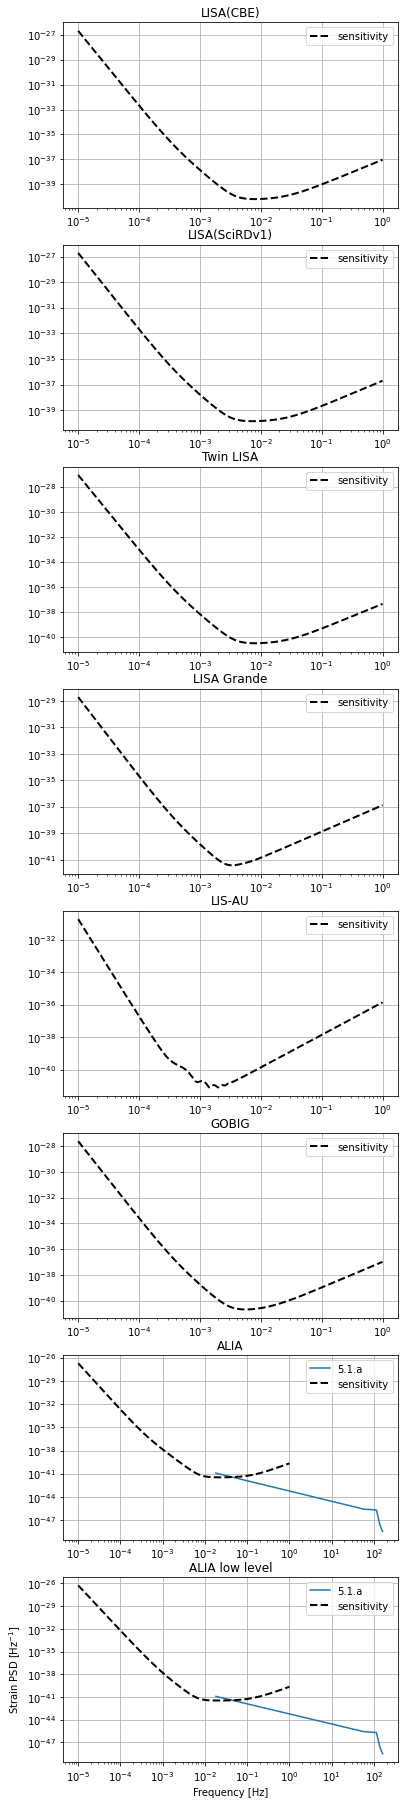

In [9]:
# sensitivity plot
#fig = plt.figure(figsize=(6,4),dpi=200)
f = np.logspace(-5,0,1000)
fig,axs=plt.subplots(len(missions),figsize=(6,4*len(missions)))
for i,mission in enumerate(missions):
    ax = axs[i]
    for ob in mission['obs']:
        if ob['source']['type']=='CW':continue
        if ob['assessment'].get('eps',10)>1:continue
        obs=metrics.getSourceSnr(ob['source'],ob['model'],4.0*constants.year)
        ax.plot(obs.get('f')[1:],np.abs(obs.get('h')[1:]**2)*np.diff(obs.get('f')),linestyle='-',label=ob.get('source').get('label'))
    
    ax.plot(f,metrics.makeSensitivity(f,mission),color = 'black', linewidth=2.0,linestyle='--',label='sensitivity')
    ax.set_title(mission['label'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain PSD [Hz$^{-1}$]')
plt.subplots_adjust()
plt.savefig('../plots/%s_source_sensitvities.png' % 'all')

# Stuff from below here could be adapted from binaryResolutionSources, but has not been.

#### SNR as a function of time plot

No handles with labels found to put in legend.


rough tstart = -126232599.05418241 0.017149934758106035 < f < 87.82452791455448
ncut= 45 n= 955
tstart = -126232599.05418241 t[0]= -128453841.73995332 0.02519709428411939 < f < 87.82452791455448
rough tstart = -126232599.05418241 0.017149934758106035 < f < 87.82452791455448
ncut= 45 n= 955
tstart = -126232599.05418241 t[0]= -128453841.73995332 0.02519709428411939 < f < 87.82452791455448


/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:618: RuntimeWarning: divide by zero encountered in true_divide
  return 4/rho2om2/Dsep**2
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:764: RuntimeWarning: invalid value encountered in reciprocal
  sig2=(sig2orb**-1+np.minimum(sig2con,sig2sep)**-1)**-1
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:618: RuntimeWarning: divide by zero encountered in true_divide
  return 4/rho2om2/Dsep**2
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:764: RuntimeWarning: invalid value encountered in reciprocal
  sig2=(sig2orb**-1+np.minimum(sig2con,sig2sep)**-1)**-1


<Figure size 1200x800 with 0 Axes>

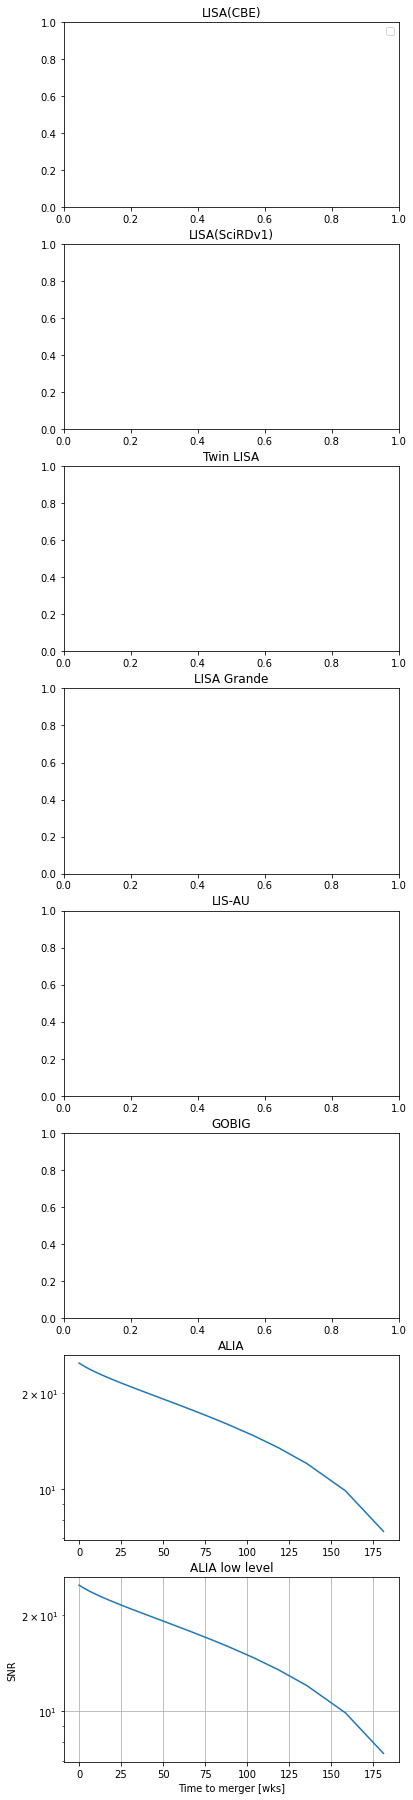

In [10]:
# SNR of time plot
fig = plt.figure(figsize=(6,4),dpi=200)
#ax = fig.add_subplot(1,1,1)
fig,axs=plt.subplots(len(missions),figsize=(6,4*len(missions)))
haveL=False
for i,mission in enumerate(missions):
    ax = axs[i]
    for ob in mission['obs']:
        ax.set_title(mission['label'])
        if ob['source']['type']=='CW':continue
        if ob['assessment'].get('eps',10)>1:continue
        obs=metrics.getSNRandSkyResolution(ob['source'],ob['model'],Nsamp=100,Tmax=4.0,SNRcut=SNRcut)
        ax.plot(-obs.get('t')*52/constants.year,obs.get('SNR of t'),linestyle='-',label=ob.get('source').get('label'))        
        ax.set_xscale('linear')
        ax.set_yscale('log')
    if not haveL:
        ax.legend()
        haveL=True
#print(obs)
#plt.xlim([-ob.get('t')[0]*52/constants.year+4,-4])
#plt.title(ob.get('source').get('label'))
plt.xlabel('Time to merger [wks]')
plt.ylabel(r'SNR')
plt.subplots_adjust()
#plt.legend()
ax.grid(True)
#plt.savefig('../plots/%s_snr_v_t.png' % modelName)

#### Angular resolution as a function of time

rough tstart = -126232599.05418241 0.017149934758106035 < f < 87.82452791455448
ncut= 45 n= 955
tstart = -126232599.05418241 t[0]= -128453841.73995332 0.02519709428411939 < f < 87.82452791455448
rough tstart = -126232599.05418241 0.017149934758106035 < f < 87.82452791455448
ncut= 45 n= 955
tstart = -126232599.05418241 t[0]= -128453841.73995332 0.02519709428411939 < f < 87.82452791455448


/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:618: RuntimeWarning: divide by zero encountered in true_divide
  return 4/rho2om2/Dsep**2
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:764: RuntimeWarning: invalid value encountered in reciprocal
  sig2=(sig2orb**-1+np.minimum(sig2con,sig2sep)**-1)**-1
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:618: RuntimeWarning: divide by zero encountered in true_divide
  return 4/rho2om2/Dsep**2
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:764: RuntimeWarning: invalid value encountered in reciprocal
  sig2=(sig2orb**-1+np.minimum(sig2con,sig2sep)**-1)**-1


<Figure size 1200x800 with 0 Axes>

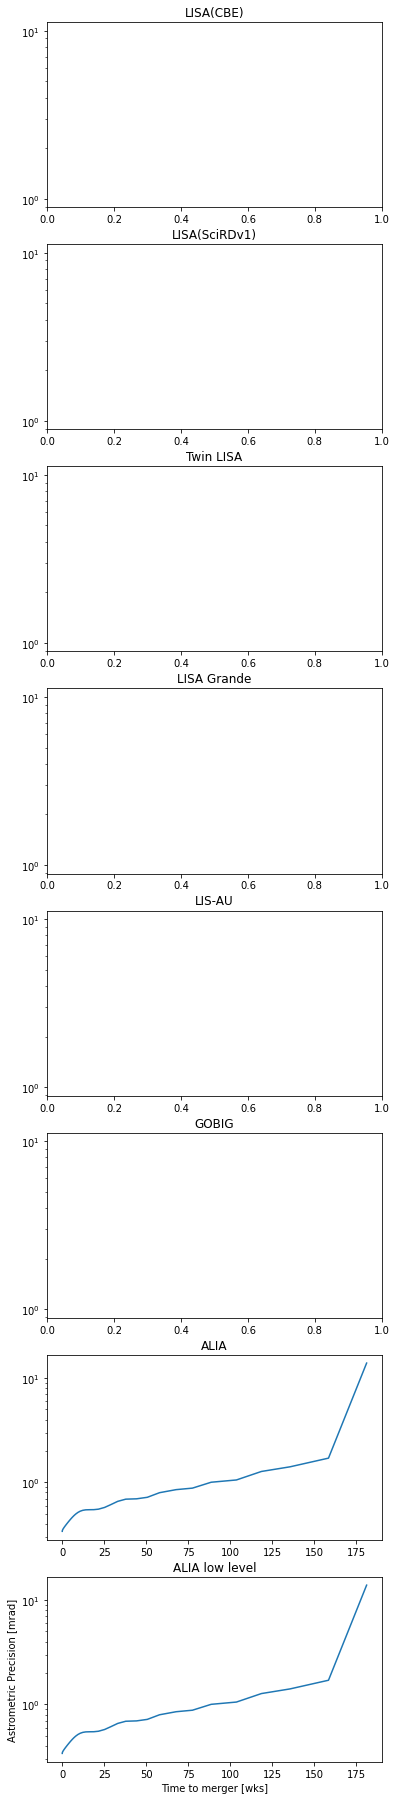

In [11]:
# Angular resolution
# SNR of time plot
fig = plt.figure(figsize=(6,4),dpi=200)
#ax = fig.add_subplot(1,1,1)
fig,axs=plt.subplots(len(missions),figsize=(6,4*len(missions)))
haveL=False
for i,mission in enumerate(missions):
    ax = axs[i]
    for ob in mission['obs']:
        ax.set_title(mission['label'])
        plt.ylabel('Astrometric Precision [mrad]')
        plt.xlabel('Time to merger [wks]')
        ax.set_xscale('linear')
        ax.set_yscale('log')
        if ob['source']['type']=='CW':continue
        if ob['assessment'].get('eps',10)>1:continue
        obs=metrics.getSNRandSkyResolution(ob['source'],ob['model'],Nsamp=100,Tmax=4.0,SNRcut=SNRcut)
        ax.plot(-obs.get('t')*52/constants.year,obs.get('Angular Resolution of t')*1e3,label= ob.get('source').get('label'))
    if False:
        ax.legend()
        haveL=True

plt.subplots_adjust()

In [12]:
getSNRandSkyResolution(source,model

SyntaxError: unexpected EOF while parsing (670878300.py, line 1)